## Homes by Zip Code
We all know 'location, location, location' is an important determination for businesses as well as homes. Let's see what type of relationship, if any, exists in home prices between zip codes.

In [1]:
# Import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
plt.style.use('seaborn-colorblind')
%matplotlib inline

In [2]:
# Read in cleaned Kings County file 
df = pd.read_csv("cleaned_kings.csv")
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,01/01/1970,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,01/01/1970,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,01/01/1970,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,01/01/1970,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,01/01/1970,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,263000018,01/01/1970,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21416,6600060120,01/01/1970,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21417,1523300141,01/01/1970,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21418,291310100,01/01/1970,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


### Visualize price by zip codes

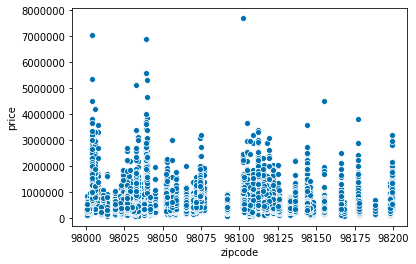

In [3]:
sns.scatterplot(x="zipcode", y="price", data=df)

### Evaluate outliers
It seems the top houses are in their own zip code or have very few homes to impact the model. For example, in zip code 98144 there are only two homes. Let's take out the top priced homes for a representative model.

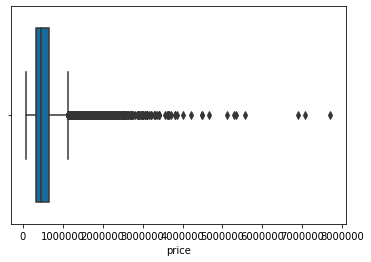

In [4]:
# Create boxplot for price
sns.boxplot(x='price', data=df);

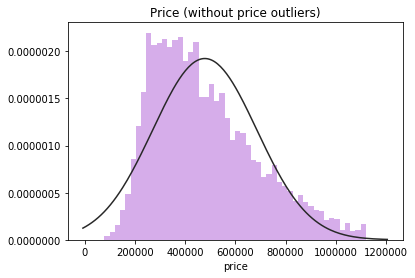

20268 21420
Number of homes excluded is 1152
Reduced homes by 5%


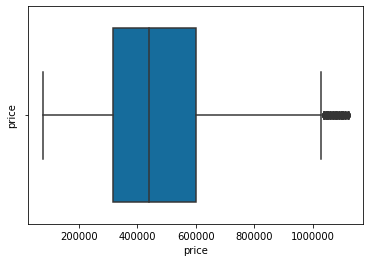

In [27]:
# Calculate the price limit for outliers using 1.5 * IQR + Q3
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
limit = 1.5 * IQR + Q3
limit

# Remove upper outliers from sqft_lot and create histogram again
df_price = df[df['price'] < limit]

# Histogram (distplot)
sns.distplot(df_price['price'], color='darkorchid', label=df_price, fit=norm, kde=False)
plt.title('Price (without price outliers)')
plt.show()
print(len(df_price), len(df))
print('Number of homes excluded is ' + str(len(df) - len(df_price)))
print('Reduced homes by ' + str(round(100 - len(df_price) / len(df) * 100)) + '%')

sns.scatterplot(x="zipcode", y="price", data=df_price)
sns.boxplot(x='price', data=df_price);

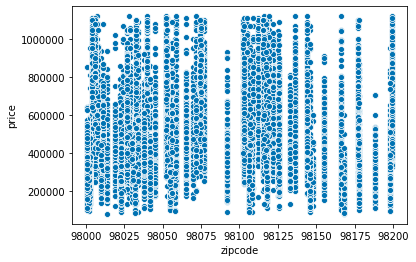

In [24]:
sns.scatterplot(x="zipcode", y="price", data=df_price)

<b>Removing the top 5% of the most expensive homes that were outliers should help to make a better predictive model.

### Zip codes are categorical and need special treatment


In [7]:
zipcodes = df_price['zipcode'].unique()
zipcodes.astype()

array([98178, 98125, 98028, 98136, 98074, 98003, 98198, 98146, 98038,
       98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133, 98092,
       98030, 98119, 98112, 98052, 98027, 98117, 98058, 98001, 98056,
       98166, 98053, 98023, 98148, 98105, 98042, 98008, 98059, 98122,
       98144, 98004, 98005, 98034, 98075, 98116, 98010, 98118, 98199,
       98040, 98032, 98045, 98102, 98077, 98108, 98168, 98177, 98065,
       98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011, 98031,
       98106, 98070, 98072, 98188, 98014, 98055, 98039])

In [8]:
# Create dummy variables for each zipcode
zip_dummy = pd.get_dummies(df_price['zipcode'])
df_zips = pd.concat([df_price, zip_dummy], axis=1)
df_zips.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,7129300520,01/01/1970,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,6414100192,01/01/1970,538000.0,3,2.25,2570,7242,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,01/01/1970,180000.0,2,1.00,770,10000,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2487200875,01/01/1970,604000.0,4,3.00,1960,5000,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,01/01/1970,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


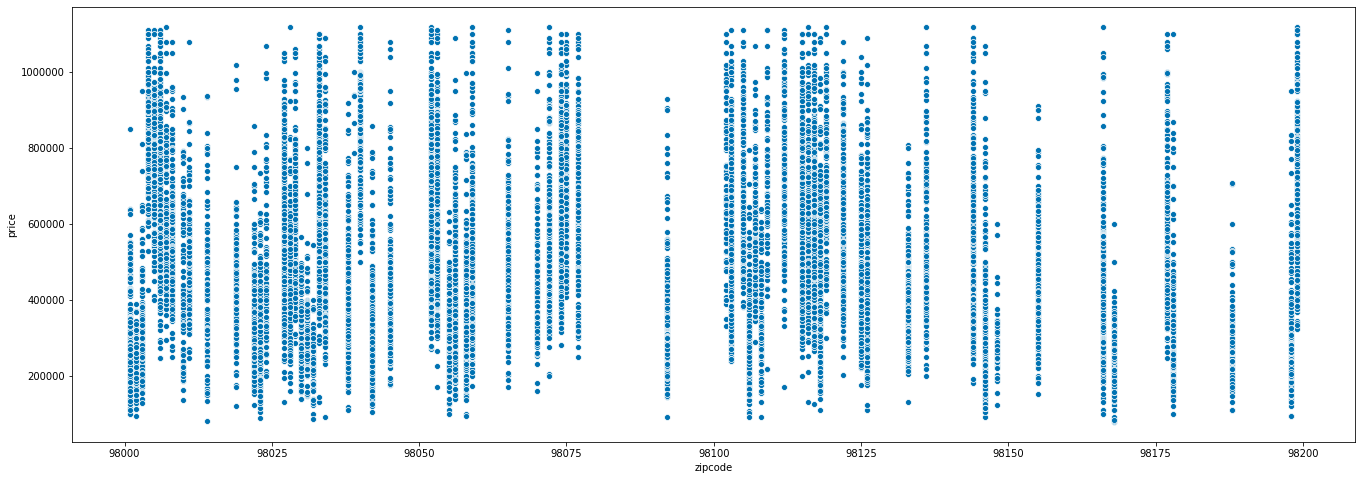

In [14]:
plt.figure(figsize=(23,8))
fig2 = sns.scatterplot(x="zipcode", y="price", data=df_price)

[Text(0, 0, '98001'),
 Text(0, 0, '98002'),
 Text(0, 0, '98003'),
 Text(0, 0, '98004'),
 Text(0, 0, '98005'),
 Text(0, 0, '98006'),
 Text(0, 0, '98007'),
 Text(0, 0, '98008'),
 Text(0, 0, '98010'),
 Text(0, 0, '98011'),
 Text(0, 0, '98014'),
 Text(0, 0, '98019'),
 Text(0, 0, '98022'),
 Text(0, 0, '98023'),
 Text(0, 0, '98024'),
 Text(0, 0, '98027'),
 Text(0, 0, '98028'),
 Text(0, 0, '98029'),
 Text(0, 0, '98030'),
 Text(0, 0, '98031'),
 Text(0, 0, '98032'),
 Text(0, 0, '98033'),
 Text(0, 0, '98034'),
 Text(0, 0, '98038'),
 Text(0, 0, '98039'),
 Text(0, 0, '98040'),
 Text(0, 0, '98042'),
 Text(0, 0, '98045'),
 Text(0, 0, '98052'),
 Text(0, 0, '98053'),
 Text(0, 0, '98055'),
 Text(0, 0, '98056'),
 Text(0, 0, '98058'),
 Text(0, 0, '98059'),
 Text(0, 0, '98065'),
 Text(0, 0, '98070'),
 Text(0, 0, '98072'),
 Text(0, 0, '98074'),
 Text(0, 0, '98075'),
 Text(0, 0, '98077'),
 Text(0, 0, '98092'),
 Text(0, 0, '98102'),
 Text(0, 0, '98103'),
 Text(0, 0, '98105'),
 Text(0, 0, '98106'),
 Text(0, 0

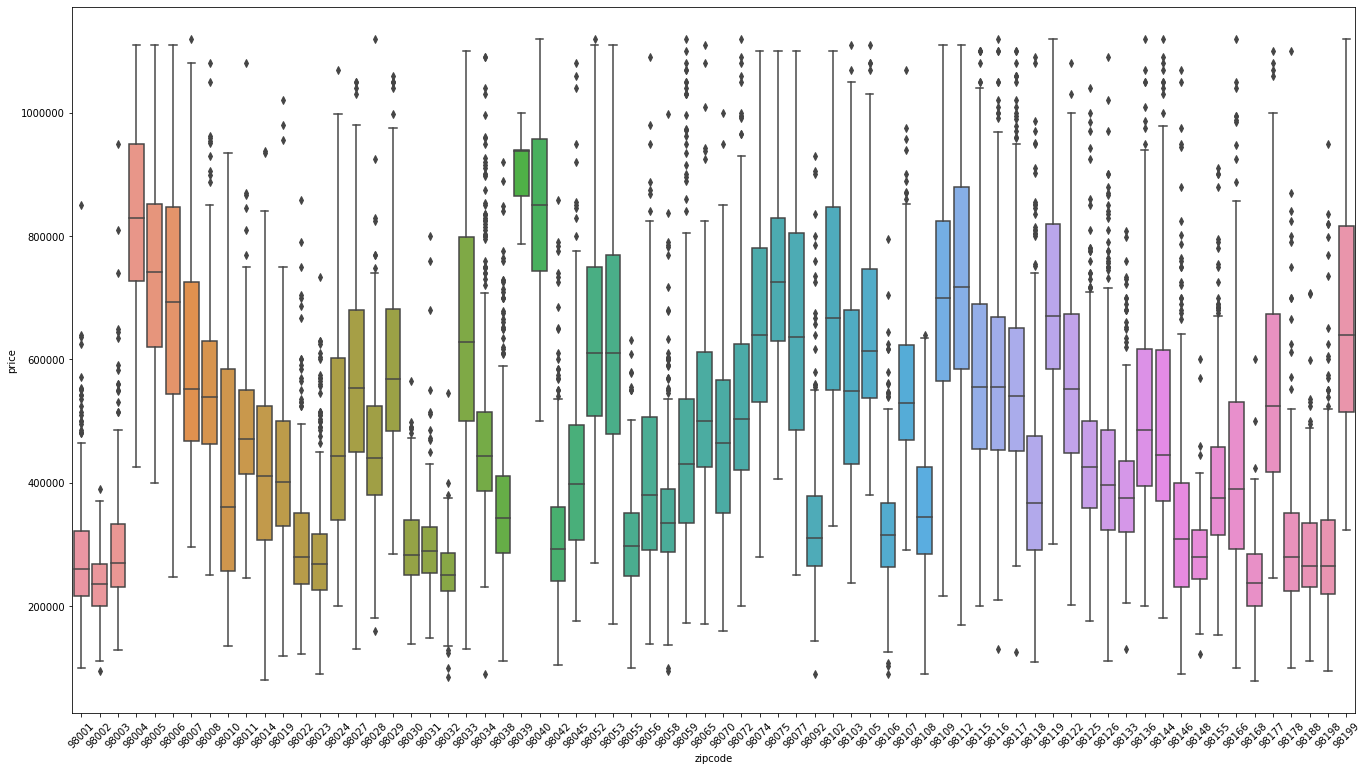

In [31]:
plt.figure(figsize=(23, 13))
fig = sns.boxplot(x="zipcode", y="price", data=df_price)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)

In [28]:
df_zips.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
count,2.026800e+04,20268.000000,20268.000000,20268.000000,2.026800e+04,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,...,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000
mean,4.781144e+05,3.329978,2.054347,1977.858545,1.462128e+04,1.477403,0.002516,0.172538,3.407786,7.535573,...,0.013618,0.002763,0.021512,0.011989,0.013025,0.011348,0.012680,0.006661,0.013470,0.013420
std,2.074405e+05,0.882864,0.709689,774.468626,4.014819e+04,0.537082,0.050101,0.640550,0.646569,1.035115,...,0.115900,0.052493,0.145086,0.108840,0.113386,0.105923,0.111892,0.081343,0.115277,0.115068
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.160000e+05,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.390000e+05,3.000000,2.000000,1860.000000,7.500000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.020000e+05,4.000000,2.500000,2440.000000,1.032000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.120000e+06,11.000000,7.500000,7480.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# cast all categorical data with a string-datatype into categorical-datatype

df.waterfront = df.waterfront.astype('category')
df.condition = df.condition.astype('category')
df.grade = df.grade.astype('category')

In [ ]:
# regression for categorical variabes
formula_str = 'price ~ ' + str(feature)
mod = ols(formula=formula_str, data=cat_features)
res = mod.fit()

res.summary()